# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Проект будет отправляться частями. Прошу проверить то, что сейчас докончено. Теоретически ускорит процесс. Спасибо!

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Открываю файл, обозначая разделитель
df = pd.read_csv("/datasets/real_estate_data.csv", sep='\t')

### Выполните предобработку данных

In [3]:
#взглянем на данные в общем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
display(df.sample(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23498,7,1600000.0,54.0,2016-12-26T00:00:00,2,2.3,1.0,33.0,1,False,...,3.5,0.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,281.0
15524,6,3750000.0,48.1,2018-03-29T00:00:00,2,NaN,5.0,29.4,5,NaN,...,5.5,NaN,Санкт-Петербург,12453.0,12366.0,0.0,NaN,1.0,298.0,65.0
4013,13,4500000.0,37.4,2019-03-18T00:00:00,1,2.7,24.0,18.5,5,NaN,...,10.1,NaN,Санкт-Петербург,31293.0,11886.0,0.0,NaN,0.0,NaN,4.0
17444,10,3000000.0,51.5,2019-02-21T00:00:00,3,NaN,5.0,NaN,4,NaN,...,5.0,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,45.0
4547,11,8800000.0,68.0,2018-12-11T00:00:00,2,2.5,25.0,32.0,16,NaN,...,12.0,NaN,Санкт-Петербург,33917.0,15016.0,0.0,NaN,1.0,1016.0,45.0


In [5]:
df.duplicated().sum()
#Явных дубликатов нет

0

Построим гистограмму всех данных.

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(dfg):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

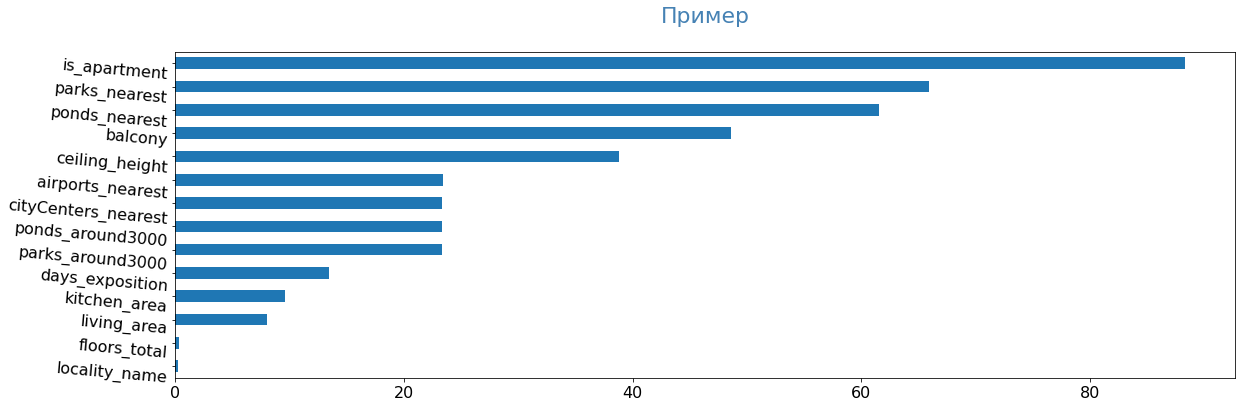

In [7]:
pass_value_barh(df)

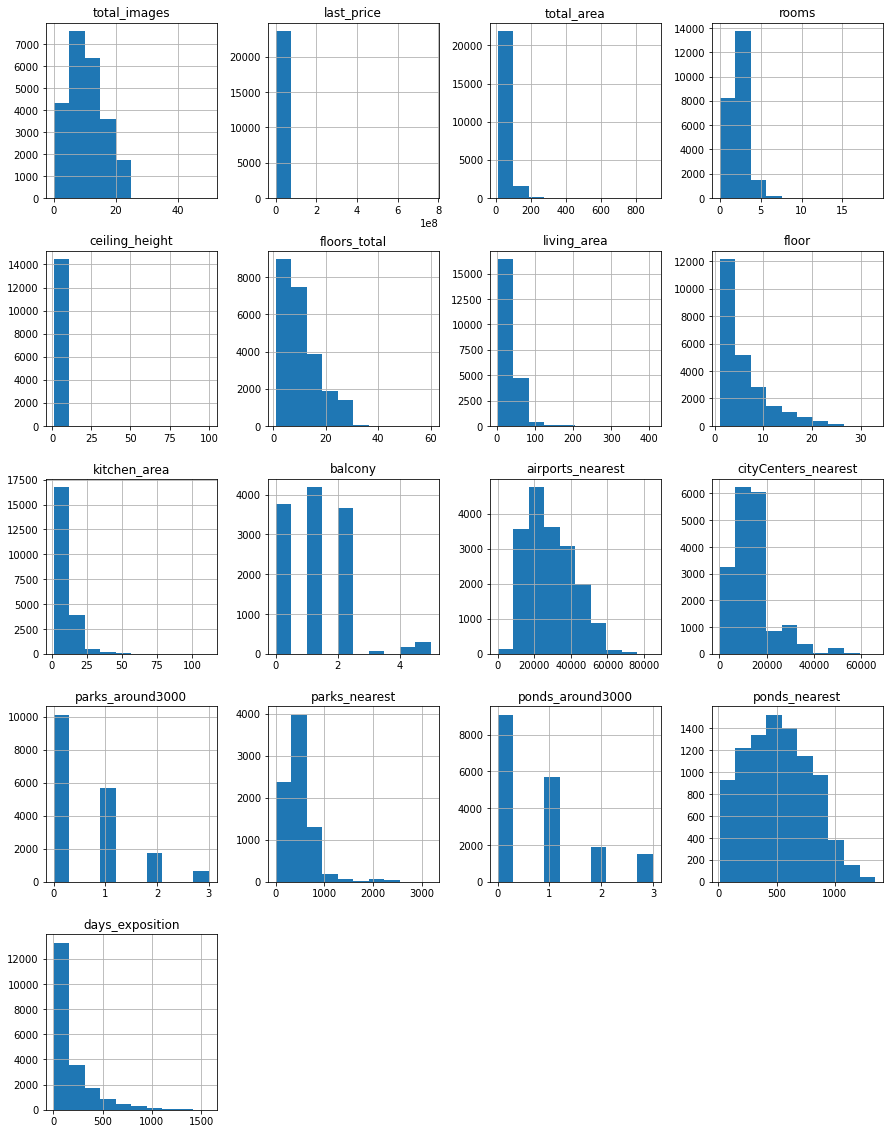

In [8]:
df.hist(figsize=(15, 20));

In [9]:
df.isna().sum()

# изменим типы данных, где это необходимо. Первое, где логически необходим целочисленны
list_to_int = ['last_price', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
               'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition', 'rooms']
#тип данных в floors_total нельзя просто взять и поменять, поскольку есть пропуски - устраним их, поскольку их очень мало


#так же список столбцов, у которых должен быть 1 знак после запятой
list_to_float_1 = ['total_area', 'ceiling_height', 'living_area', 'kitchen_area']
#так же список столбцов, у которых должно быть 2 знака после запятой
    

In [10]:
#Добавим все необходимые столбцы.
df['price_of_m2'] = df['last_price']/df['total_area']
#необходимо для месяца и года публикации объявления, а так же для недели.
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['year'] = df['first_day_exposition'].apply(lambda x: x.year)
df['month'] = df['first_day_exposition'].apply(lambda x: x.month)
df['day'] = df['first_day_exposition'].apply(lambda x: x.isoweekday())
df['level'] = np.where(df['floor'] == 1, 'первый', 'другой')
df['level'] = np.where((df['floor'] == df['floors_total']) & (df['floors_total'] != 1), 'последний', df['level'])

In [11]:
# изменяем тип данных для столбцов, где необходим целочисленный.
for column in list_to_int:
    df[column] = df[df[column].notnull()][column].astype('int64').round(0)
    

In [12]:
#Далее числа с одним знаком после запятой.
for column in list_to_float_1:
    df[column] = df[df[column].notnull()][column].astype('float64').round(1)

In [13]:

df['price_of_m2'] = df['price_of_m2'].astype('float64').round(2)

In [14]:
#Теперь посмотрим на уникальные значения столбцов, чтобы найти неявные дубликаты
columns = df.columns
for column in columns:
    #print(df[column].unique())
    #Работаем со столбцом с населенными пунктами. 
    pass

In [15]:
# наблюдаем неявные дубликаты
locality_dups = df['locality_name'].unique()
df['locality_name'] = (
    df['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок'], 'поселок', regex=True)
)
# Дубликаты исправлены
#print(df['locality_name'].unique())


#### check name

In [16]:
# check
df.locality_name.nunique()

322

Просмотрим данные после изменений

In [17]:
print(df.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64


### Причины возникновения
Рассмотрим дубликаты, которые у нас получились.
ceiling_height - Вероятнее всего клиент не имел этих данных на тот момент, потому данные и не введены. Стоит заменить на 0.
Либо в дальнейшем на медианное значение
floors_total - вероятнее всего NaN значения - это отсутствие этажности здания. А то есть одноэтажное здание. Требуется доп анализ,Чтобы утверждать наверняка
living_area - Не может быть равно нулю. Нужно узнать суть проблемы и выяснить с чем связаны пропуски.  
is apartment - имеет только два значения, а то есть является булевым. Вероятнее всего NaN это банально False. Можно произвести замену 
balcony - Пропуски вероятнее всего показывают отсутствие балкона, то есть можно заменить на 0
Группа "nearest" - пропуски могли возникнуть в следствии сбоев в системе навигаторов, либо оплошности заполняещего, который не
Мог определить, где ближайший N-ый объект. Стоит заменить медианным значением.
Группа 'around' Вероятна ошибка в заполнении. Нужно выяснить источник проблемы. При возможности отправить запрос в ТП.
kitchen_area - требуется дополнительный анализ. Нельзя наверняка утрверждать, что данные пропущены - их может не быть в случае, когда 
кухня соединена с залом.
days_exposition, предположу, что можно заменить на ноль. Если значение NaN значит объявление банально не было выставлено
locality_name - Определенно точно не вписали данные, поскольку это пользовательская информация.



#### check gap

In [18]:
# check
data = df.copy()

In [19]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

<div style>
<font size="4"><b></b></font>
<font size="5", color = "black">
👍

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [21]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","14,504.00","20,518.00","23,699.00","21,796.00","21,421.00","23,699.00","23,613.00"
min,0.00,12.00,1.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,100.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [22]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [23]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


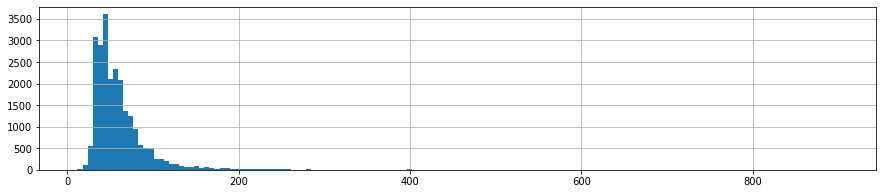

In [24]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

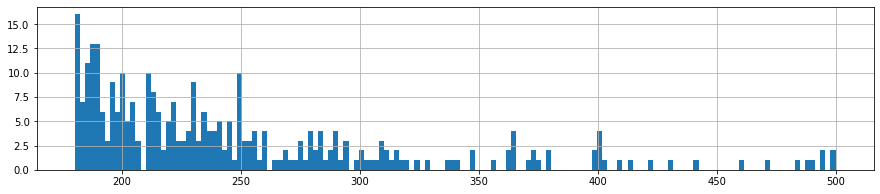

In [25]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

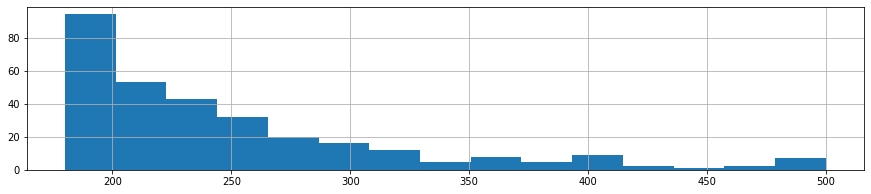

In [26]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

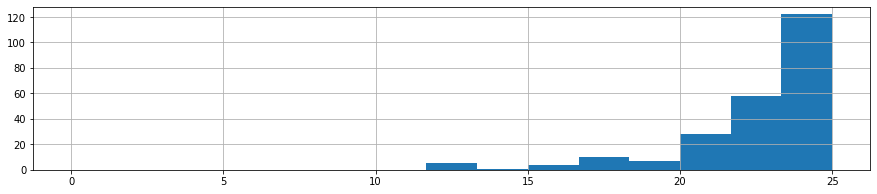

In [27]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [28]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.00,2.30,3.00,"562,188.00",10.00,3.77,1.00,2.00
0.01,1.00,25.20,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.5,2.00,52.00,2.60,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.99,5.00,197.21,3.80,"1,068.66","36,000,000.00",120.00,35.08,23.00,26.00
0.9988,8.00,380.00,25.00,"1,369.90","124,772,448.00",219.69,60.00,26.00,35.00


### Добавьте в таблицу новые столбцы

Столбцы добавлены выше.

### Проведите исследовательский анализ данных

Выведем гистограммы для каждого столбца

Поскольку last_price не отображается корректно, поделю эти числа на 1000.

In [29]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

Видно, что есть ОГРОМНОЕ количество в группах nearest и around от 10 процентов от всех данных.
Начнем рассматривать по очереди

In [30]:
df['living_area'].describe()

count    21796.000000
mean        34.457878
std         22.030420
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Минимальное значение очень подозрительное - похоже, что этого не может, рассмотрим подетальнее

In [31]:
df.sort_values(by='living_area').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
21758,0,2330000,23.0,2018-01-01,0,NaN,24.0,2.0,22,NaN,...,NaN,NaN,NaN,NaN,66.0,101304.35,2018,1,1,другой
13915,20,6350000,52.0,2018-02-06,2,3.0,6.0,2.0,2,NaN,...,0.0,NaN,1.0,1012.0,91.0,122115.38,2018,2,2,другой
3242,7,4440000,41.0,2017-07-02,1,NaN,17.0,3.0,17,NaN,...,0.0,NaN,0.0,NaN,216.0,108292.68,2017,7,7,последний
23574,14,64990000,139.0,2015-11-24,3,3.0,8.0,3.0,8,NaN,...,1.0,630.0,3.0,100.0,280.0,467553.96,2015,11,2,последний
17582,11,2680000,22.0,2018-08-11,0,NaN,25.0,5.0,8,NaN,...,1.0,835.0,1.0,652.0,70.0,121818.18,2018,8,6,другой
21943,15,6100000,77.6,2019-02-28,4,2.5,9.0,5.4,1,NaN,...,1.0,584.0,0.0,NaN,33.0,78608.25,2019,2,4,первый
16431,13,3799000,31.0,2018-04-12,1,2.6,5.0,6.0,1,NaN,...,1.0,430.0,0.0,NaN,168.0,122548.39,2018,4,4,первый
19251,19,4050000,33.0,2018-10-15,1,2.5,22.0,6.5,21,NaN,...,1.0,458.0,0.0,NaN,44.0,122727.27,2018,10,1,другой
20994,7,8900000,50.6,2018-10-22,2,2.5,7.0,8.0,3,NaN,...,1.0,173.0,3.0,126.0,NaN,175889.33,2018,10,1,другой
23208,12,4800000,37.0,2016-02-24,1,NaN,14.0,8.0,11,NaN,...,2.0,358.0,1.0,950.0,139.0,129729.73,2016,2,3,другой


Выглядит достаточно равномерно, не осмелюсь трогать. Так же можно заметить, что в столбцах с кухней есть пропуски в значениях, то есть просто вычислить не выйдет. Буду заменять медианным значением

In [32]:
df['living_area'] = df['living_area'].fillna(df.groupby('rooms')['living_area'].transform('median'))
#пропуски на данный момент
display(df['living_area'].isna().sum())
df.isna().sum()

0

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

Рассмотрим высоту потолков. Сразу убираем квартиру с потолков в 100 метров, этого не может быть

In [33]:
df = df[df['ceiling_height'] != 100]
df['ceiling_height'].describe()

count    14503.000000
mean         2.769013
std          0.968634
min          1.000000
25%          2.500000
50%          2.600000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

Рассмотрим квартиры с потолками выше 11 метров.

In [34]:
df[df['ceiling_height'] > 11]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
355,17,3600000,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,NaN,NaN,NaN,259.0,65217.39,2018,7,4,другой
3148,14,2900000,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,NaN,NaN,NaN,NaN,NaN,38666.67,2018,11,1,другой
4643,0,4300000,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,...,1.0,658.0,1.0,331.0,181.0,95555.56,2018,2,4,другой
4876,7,3000000,25.0,2017-09-27,0,27.0,25.0,17.0,17,NaN,...,NaN,NaN,NaN,NaN,28.0,120000.00,2017,9,3,другой
5076,0,3850000,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,...,3.0,397.0,1.0,578.0,7.0,126229.51,2018,10,3,первый
5246,0,2500000,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,NaN,NaN,NaN,NaN,540.0,46296.30,2017,10,5,другой
5669,4,4400000,50.0,2017-08-08,2,26.0,9.0,21.3,3,NaN,...,1.0,305.0,0.0,NaN,267.0,88000.00,2017,8,2,другой
5807,17,8150000,80.0,2019-01-09,2,27.0,36.0,41.0,13,NaN,...,0.0,NaN,3.0,80.0,38.0,101875.00,2019,1,3,другой
6246,6,3300000,44.4,2019-03-25,2,25.0,5.0,31.3,5,NaN,...,1.0,417.0,2.0,73.0,NaN,74324.32,2019,3,1,последний
9379,5,3950000,42.0,2017-03-26,3,25.0,5.0,30.0,2,NaN,...,0.0,NaN,0.0,NaN,NaN,94047.62,2017,3,7,другой


Отлично, можно заметить, что квартиры с высотой больше 11 это нормальные квартиры по остальным параметрам. Есть смысл поделить на 10 и посмотреть, что выйдет

In [35]:
df.loc[df['ceiling_height'] > 11, 'ceiling_height'] /= 10
df['ceiling_height'].describe()

count    14503.000000
mean         2.732456
std          0.300212
min          1.000000
25%          2.500000
50%          2.600000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

Тем не менее у нас есть квартиры, которые ниже 2 метров, в таких квартирах жить нельзя, выведем их список

In [36]:
df.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
5712,5,1500000,42.8,2017-08-14,2,1.2,2.0,27.5,1,NaN,...,NaN,NaN,NaN,NaN,248.0,35046.73,2017,8,1,первый
15061,19,5600000,56.4,2018-05-11,2,1.4,14.0,32.4,5,NaN,...,0.0,NaN,0.0,NaN,315.0,99290.78,2018,5,5,другой
16934,5,4100000,40.0,2017-10-17,1,1.8,37.0,17.4,5,NaN,...,0.0,NaN,3.0,80.0,71.0,102500.00,2017,10,2,другой
22590,16,6000000,55.0,2018-10-31,2,1.0,12.0,32.4,7,NaN,...,2.0,293.0,2.0,289.0,13.0,109090.91,2018,10,3,другой


Таких квартир всего 4. Что радует. В остальном они выглядят нормально. Можно к высоте потолка прибавить примерно полтора метра.

In [37]:
df.loc[df['ceiling_height'] < 2, 'ceiling_height'] += 1.5 
df['ceiling_height'].describe()

count    14503.000000
mean         2.732870
std          0.299339
min          2.000000
25%          2.500000
50%          2.600000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

Так, остались квартиры с очень высокими потолками, рассмотрим и их.

In [38]:
df.query('ceiling_height > 3.5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
154,1,8200000,80.0,2018-11-06,3,4.2,3.0,44.2,2,NaN,...,2.0,344.0,1.0,838.0,38.0,102500.00,2018,11,2,другой
179,5,14800000,108.7,2019-04-11,3,4.0,5.0,72.4,5,NaN,...,1.0,559.0,0.0,NaN,NaN,136154.55,2019,4,4,последний
368,19,12500000,85.0,2018-09-21,3,3.7,6.0,56.5,6,NaN,...,2.0,516.0,1.0,36.0,4.0,147058.82,2018,9,5,последний
464,15,66571000,280.3,2015-06-11,6,5.2,8.0,159.5,7,NaN,...,3.0,187.0,1.0,616.0,578.0,237499.11,2015,6,4,другой
635,17,25990000,133.9,2018-03-16,4,3.6,3.0,75.0,3,NaN,...,0.0,NaN,3.0,418.0,NaN,194100.07,2018,3,5,последний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23014,8,2250000,28.3,2017-08-04,1,3.7,3.0,10.9,2,NaN,...,2.0,170.0,3.0,110.0,424.0,79505.30,2017,8,5,другой
23330,6,19900000,144.0,2017-01-09,3,3.8,5.0,79.5,3,NaN,...,2.0,521.0,0.0,NaN,NaN,138194.44,2017,1,1,другой
23382,2,15000000,150.9,2016-07-04,4,3.7,4.0,98.2,3,NaN,...,3.0,105.0,1.0,614.0,455.0,99403.58,2016,7,1,другой
23573,8,6290000,47.7,2019-03-20,1,3.6,12.0,13.6,12,NaN,...,1.0,253.0,2.0,99.0,19.0,131948.81,2019,3,3,последний


Отлично, их немного, и это достаточно крупные квартиры. Оставлю, выглядит правдоподобно.

In [39]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

Заполняем медианными значениями.

In [40]:
df['ceiling_height'].isna().sum()

0

In [41]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

Дальше рассмотрим столбец floor_total. Сразу отсортируем список по количеству этажей.

In [42]:
df['floors_total'].describe()

count    23612.000000
mean        10.674064
std          6.597209
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

 Сразу отсортируем список по количеству этажей.

In [43]:
df[df['floors_total'].isna()].sort_values(by='floor')


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
237,4,2438033,28.1,2016-11-23,1,2.6,NaN,20.8,1,NaN,...,0.0,NaN,1.0,374.0,251.0,86762.74,2016,11,3,первый
15989,1,4100000,74.5,2017-04-22,3,2.6,NaN,45.0,1,NaN,...,0.0,NaN,0.0,NaN,72.0,55033.56,2017,4,6,первый
3817,1,1640000,24.0,2015-08-25,1,2.6,NaN,17.6,1,NaN,...,0.0,NaN,0.0,NaN,378.0,68390.33,2015,8,2,первый
20250,5,6060000,60.6,2015-10-29,2,2.8,NaN,30.5,2,NaN,...,0.0,NaN,1.0,830.0,1257.0,100000.00,2015,10,4,другой
9979,3,4100000,35.0,2016-09-27,1,2.6,NaN,17.6,2,NaN,...,0.0,NaN,0.0,NaN,173.0,117142.86,2016,9,2,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8478,19,13500000,77.8,2019-04-17,2,2.8,NaN,39.4,21,NaN,...,1.0,593.0,1.0,130.0,NaN,173521.85,2019,4,3,другой
2392,7,5395770,53.0,2017-06-29,2,2.6,NaN,29.0,22,NaN,...,0.0,NaN,0.0,NaN,48.0,101806.98,2017,6,4,другой
14264,13,14000000,94.0,2019-01-23,6,2.6,NaN,51.0,23,NaN,...,0.0,NaN,0.0,NaN,NaN,148936.17,2019,1,3,другой
6030,3,10900000,116.2,2017-05-05,4,2.6,NaN,63.6,24,NaN,...,0.0,NaN,1.0,844.0,83.0,93779.57,2017,5,5,другой


Пропущенных значений очень мало. Избавлюсь от этих значений.

In [44]:
df.dropna(subset=['floors_total'], inplace=True)

In [45]:
df['floors_total'] = df['floors_total'].astype('int64')

Далее столбец is_apartment. Предположу, что пропуски связаны с тем, что значение просто не вписывали, поскольку квартира не являлась апартаментом. Заменю на False

In [46]:
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False

In [47]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2231
balcony                 11480
locality_name              48
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15568
ponds_around3000         5508
ponds_nearest           14552
days_exposition          3172
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

In [48]:
df['floor']

0         8
1         1
2         4
3         9
4        13
         ..
23694     3
23695     4
23696     1
23697    12
23698     1
Name: floor, Length: 23612, dtype: int64

В процессе выяснилось, что имеются квартиры с количеством комнат 0. Это незначительное количество, потому можно просто избавится от них.









In [49]:
df = df[df['rooms'] != 0]

Далее рассмотрим kitchen_area. Похоже, стоит сгруппировать по комнатам, чтобы найти актуальные медианы. В противном случае данные могут исказится. Проделаю это.

In [50]:
df['kitchen_area'].describe()

count    21381.000000
mean        10.564052
std          5.904463
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [51]:
df.pivot_table(index='rooms', values='kitchen_area', aggfunc=('median', 'count'))


,count,median
rooms,,
1,7202,9.00
2,7270,8.70
3,5369,9.50
4,1080,11.05
5,285,15.10
6,96,19.75
7,52,20.00
8,9,25.00
9,7,14.30


Как можно увидеть в квартирах с разным количеством комнат медиана площади сильно разнится. Потому есть смысл подставлять медианны в зависимости от количества комнат в квартире

In [52]:
df['kitchen_area'].fillna(df.groupby('rooms')['kitchen_area'].transform('median'), inplace=True)


In [53]:
df.query('total_area*0.8 <= (living_area + kitchen_area)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
9,18,5400000,61.0,2017-02-26,3,2.5,9,43.6,7,False,...,0.0,NaN,0.0,NaN,289.0,88524.59,2017,2,7,другой
11,9,3300000,44.0,2018-08-27,2,2.6,5,31.0,4,False,...,0.0,NaN,0.0,NaN,7.0,75000.00,2018,8,1,другой
18,8,3250000,31.0,2017-01-27,1,2.5,5,19.4,2,False,...,1.0,759.0,0.0,NaN,168.0,104838.71,2017,1,5,другой
26,6,4050000,60.0,2017-04-28,4,2.6,5,43.0,4,False,...,0.0,NaN,1.0,95.0,265.0,67500.00,2017,4,5,другой
27,20,7100000,70.0,2017-05-12,3,2.6,17,49.0,11,False,...,2.0,452.0,1.0,779.0,151.0,101428.57,2017,5,5,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23643,1,660000,45.0,2019-02-19,2,2.6,5,31.0,4,False,...,NaN,NaN,NaN,NaN,NaN,14666.67,2019,2,2,другой
23663,12,6400000,88.0,2018-01-12,4,2.6,10,63.6,1,False,...,0.0,NaN,2.0,844.0,59.0,72727.27,2018,1,5,первый
23680,14,5000000,59.0,2019-04-04,3,2.5,5,52.0,1,False,...,0.0,NaN,0.0,NaN,NaN,84745.76,2019,4,4,первый
23681,13,5250000,43.0,2018-05-11,2,2.5,5,29.0,2,False,...,1.0,497.0,2.0,660.0,80.0,122093.02,2018,5,5,другой


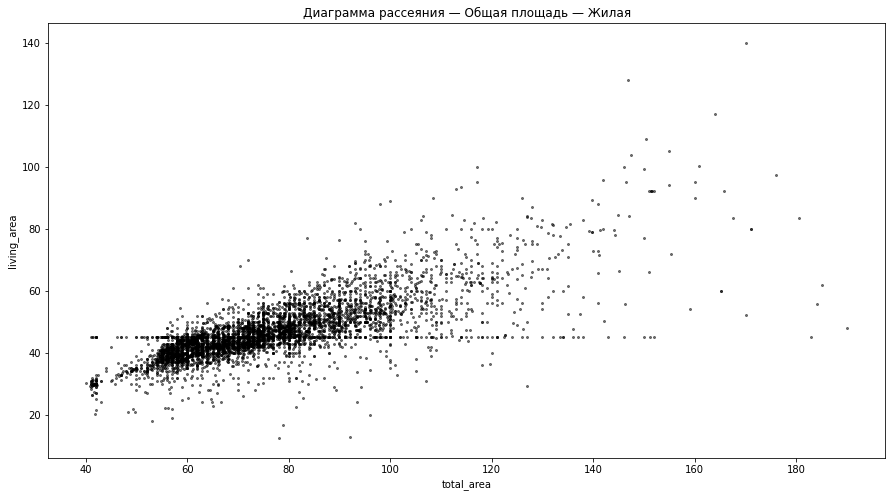

In [54]:
# check
df[df['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

In [55]:
df['kitchen_area'].isna().sum()

0

In [56]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11412
locality_name              48
airports_nearest         5455
cityCenters_nearest      5432
parks_around3000         5431
parks_nearest           15402
ponds_around3000         5431
ponds_nearest           14426
days_exposition          3158
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

In [57]:
df['floors_total'].dtypes

dtype('int64')

Теперь посмотрим на пропуски в столбце с количеством балконов. Вероятнее всего, если значение NaN, то балкона просто нет, на этом предположении и остановимся. Заменяю пропуски 0.

In [58]:
df['balcony'].fillna(0, inplace=True)

In [59]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              48
airports_nearest         5455
cityCenters_nearest      5432
parks_around3000         5431
parks_nearest           15402
ponds_around3000         5431
ponds_nearest           14426
days_exposition          3158
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

Столбец с расположением квартиры. Рассмотрим поближе

In [60]:
df['locality_name'].isna().sum()

48

Пропусков очень мало, просто избавимся от них

In [61]:
df = df.dropna(subset=['locality_name']).reset_index(drop=True)

In [62]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5447
cityCenters_nearest      5424
parks_around3000         5423
parks_nearest           15369
ponds_around3000         5423
ponds_nearest           14403
days_exposition          3157
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

Теперь рассмотрим ближайшие аэропорты

In [63]:
def fill_na(df):
    for col in ['cityCenters_nearest', 'airports_nearest']:
        df[col].fillna(df.groupby('locality_name')[col].median(), inplace=True)
    return df

df = fill_na(df.copy())
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna((df.groupby('locality_name')['cityCenters_nearest'].median()).median())
df['parks_nearest'] = df['parks_nearest'].fillna((df.groupby('locality_name')['parks_nearest'].median()).median())


In [64]:
df['airports_nearest'].isna().sum()

5447

Теоретически пропуски могут возникать от того, слишком ли далеко аэропорт, или слишком близко. Нужно проверить

In [65]:
df['airports_nearest'].describe()

count    17923.000000
mean     28824.583050
std      12629.631166
min          0.000000
25%      18583.500000
50%      26770.000000
75%      37291.000000
max      84869.000000
Name: airports_nearest, dtype: float64

отсортирую по растоянию

In [66]:
df.sort_values(by='airports_nearest', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
9514,8,4200000,51.4,2014-12-10,2,2.6,5,31.0,2,False,...,0.0,396.25,0.0,NaN,1194.0,81712.06,2014,12,3,другой
5265,19,3600000,50.6,2019-03-19,2,2.5,5,29.9,4,False,...,0.0,396.25,0.0,NaN,NaN,71146.25,2019,3,2,другой
570,7,4000000,59.0,2017-07-23,3,2.5,5,37.0,1,False,...,0.0,396.25,0.0,NaN,NaN,67796.61,2017,7,7,первый
20461,1,3300000,43.5,2016-02-16,2,2.6,4,27.2,2,False,...,0.0,396.25,0.0,NaN,1043.0,75862.07,2016,2,2,другой
5145,15,3650000,53.8,2018-09-24,3,2.5,4,36.9,3,False,...,0.0,396.25,0.0,NaN,121.0,67843.87,2018,9,1,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23354,16,2100000,62.8,2018-09-18,4,2.5,5,45.5,3,False,...,NaN,396.25,NaN,NaN,NaN,33439.49,2018,9,2,другой
23363,2,1350000,30.0,2017-07-07,1,2.6,5,17.5,4,False,...,NaN,396.25,NaN,NaN,413.0,45000.00,2017,7,5,другой
23366,14,3100000,59.0,2018-01-15,3,2.6,5,38.0,4,False,...,NaN,396.25,NaN,NaN,45.0,52542.37,2018,1,1,другой
23367,18,2500000,56.7,2018-02-11,2,2.6,3,29.7,1,False,...,NaN,396.25,NaN,NaN,NaN,44091.71,2018,2,7,первый


Изначальная гипотеза провалилась. Потому заполню медианным значением по населенным пунктам

In [67]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5447
cityCenters_nearest         0
parks_around3000         5423
parks_nearest               0
ponds_around3000         5423
ponds_nearest           14403
days_exposition          3157
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

In [68]:
df['cityCenters_nearest'].isna().sum()

0

Ситуация с ближайшими центрами города, похожа. Поступлю таким же образом

In [69]:
df['cityCenters_nearest'].describe()

count    23370.000000
mean     18000.991271
std      10250.088605
min        181.000000
25%      10912.000000
50%      14983.000000
75%      30583.250000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [70]:
df.pivot_table(
    index='locality_name', values='cityCenters_nearest', aggfunc=('median')
)

,cityCenters_nearest
locality_name,
Бокситогорск,30583.25
Волосово,30583.25
Волхов,30583.25
Всеволожск,30583.25
Выборг,30583.25
...,...
село Путилово,30583.25
село Рождествено,30583.25
село Русско-Высоцкое,30583.25


In [71]:
df['cityCenters_nearest'].fillna(df.groupby('locality_name')['cityCenters_nearest'].median(), inplace=True)



In [72]:
df.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc='median')

,cityCenters_nearest
locality_name,
Бокситогорск,30583.25
Волосово,30583.25
Волхов,30583.25
Всеволожск,30583.25
Выборг,30583.25
...,...
село Путилово,30583.25
село Рождествено,30583.25
село Русско-Высоцкое,30583.25


In [73]:
df['cityCenters_nearest'].isna().sum()

0

In [74]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5447
cityCenters_nearest         0
parks_around3000         5423
parks_nearest               0
ponds_around3000         5423
ponds_nearest           14403
days_exposition          3157
price_of_m2                 0
year                        0
month                       0
day                         0
level                       0
dtype: int64

Дальше ближайшие парки. Сделаем как и с прошлыми подгруппами в этой группе 'nearest'

In [75]:
df['parks_nearest'].isna().sum()

df.sort_values(by='parks_nearest')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
14426,8,3770000,45.4,2019-03-20,2,2.6,9,28.4,2,False,...,1.0,1.0,0.0,NaN,42.0,83039.65,2019,3,3,другой
11782,7,4500000,44.0,2017-11-24,2,2.6,9,30.0,7,False,...,1.0,3.0,1.0,508.0,82.0,102272.73,2017,11,5,другой
22620,8,10965000,69.3,2019-01-10,1,3.0,4,48.9,4,True,...,3.0,4.0,1.0,217.0,110.0,158225.11,2019,1,4,последний
9225,12,3000000,28.1,2017-07-25,1,2.5,9,17.0,1,False,...,1.0,7.0,1.0,780.0,440.0,106761.57,2017,7,2,первый
19916,3,11809670,102.6,2017-04-21,3,2.6,9,45.0,3,False,...,2.0,9.0,2.0,480.0,90.0,115104.00,2017,4,5,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22759,15,4650000,44.5,2018-02-20,2,2.6,5,25.2,2,False,...,1.0,2984.0,1.0,284.0,152.0,104494.38,2018,2,2,другой
18947,17,14950000,187.0,2017-10-12,5,3.0,2,80.0,2,False,...,0.0,3013.0,3.0,537.0,49.0,79946.52,2017,10,4,последний
1568,3,7500000,70.0,2017-07-11,2,2.6,18,37.0,13,False,...,0.0,3064.0,1.0,264.0,4.0,107142.86,2017,7,2,другой
10806,9,3000000,31.1,2017-03-21,1,2.6,5,17.7,2,False,...,0.0,3190.0,1.0,431.0,234.0,96463.02,2017,3,2,другой


Можно заметить, что большинство пропусков в конце, есть смысл заменить максимальным доступным значением.

In [76]:
df['parks_nearest'] = df['parks_nearest'].fillna(df['parks_nearest'].max())

Теперь ближайшие пруды. Есть смысл проверить, есть ли в радиусе 3 километров водоёмы, и если нет, значит пруды находятся дальше трех километров. Эти пропущенные значения мы будем заменять максимальными

In [77]:
df['ponds_nearest'].isna().sum()

14403

In [78]:
len(df.query('ponds_around3000 == 0 in (ponds_nearest.isna())'))

8980

Таковых значений много, но картина неизменна, заменим максимальным значением.

In [79]:
df['ponds_nearest'] = df['ponds_nearest'].fillna(df['parks_nearest'].max())

In [80]:
df.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5447
cityCenters_nearest        0
parks_around3000        5423
parks_nearest              0
ponds_around3000        5423
ponds_nearest              0
days_exposition         3157
price_of_m2                0
year                       0
month                      0
day                        0
level                      0
dtype: int64

Далее идет группа around. Рассмотрим ближайшие пруды.

In [81]:
df['ponds_around3000'].value_counts()

0.0    8980
1.0    5614
2.0    1871
3.0    1482
Name: ponds_around3000, dtype: int64

Предположим, чот пропуски это отсутствие водоемов в 3-х километровой доступности, просто заменим пропуски на 0.

In [82]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

Далее рассмотрим парки в трех киллометрах

In [83]:
df['ponds_around3000'].value_counts()

0.0    14403
1.0     5614
2.0     1871
3.0     1482
Name: ponds_around3000, dtype: int64

С парками предполагаю, что так же. Произведу замену

In [84]:
df['parks_around3000'].value_counts()

0.0    9950
1.0    5624
2.0    1730
3.0     643
Name: parks_around3000, dtype: int64

In [85]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)

In [86]:
df.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5447
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3157
price_of_m2                0
year                       0
month                      0
day                        0
level                      0
dtype: int64

Последнее, что осталось обработать, это сколько объявление уже весит на стене объявлений

In [87]:
display(df['days_exposition'].isna().sum())
display(df['days_exposition'].describe())

3157

count    20213.00000
mean       181.37649
std        220.09685
min          1.00000
25%         45.00000
50%         96.00000
75%        232.00000
max       1580.00000
Name: days_exposition, dtype: float64

посмотрим крайние даты

In [88]:
display(df[df['days_exposition'].isna()].sort_values(by='first_day_exposition', ascending=False).head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
11836,10,950000,37.1,2019-05-03,1,2.6,4,17.0,4,False,...,0.0,396.25,0.0,3190.0,NaN,25606.47,2019,5,5,последний
17628,3,4650000,34.8,2019-05-03,1,2.5,9,13.9,1,False,...,0.0,396.25,1.0,396.0,NaN,133620.69,2019,5,5,первый
14873,5,1400000,34.0,2019-05-03,1,2.5,5,17.6,2,False,...,0.0,396.25,0.0,3190.0,NaN,41176.47,2019,5,5,другой
2148,10,5100000,51.0,2019-05-03,1,2.6,9,15.0,2,False,...,0.0,396.25,0.0,3190.0,NaN,100000.00,2019,5,5,другой
4390,13,3500000,34.6,2019-05-03,1,2.5,5,19.4,3,False,...,1.0,361.00,0.0,3190.0,NaN,101156.07,2019,5,5,другой


In [89]:
df[df['days_exposition'].isna()].sort_values(by='first_day_exposition').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level
3245,8,8200000,52.5,2014-11-27,1,2.6,8,21.5,2,False,...,1.0,537.00,0.0,3190.0,NaN,156190.48,2014,11,4,другой
15645,6,25000000,145.2,2014-11-27,3,2.6,5,60.7,5,False,...,0.0,396.25,0.0,3190.0,NaN,172176.31,2014,11,4,последний
3821,7,20100000,117.6,2014-11-27,3,2.6,8,62.5,7,False,...,1.0,537.00,0.0,3190.0,NaN,170918.37,2014,11,4,другой
6829,17,29999000,133.5,2014-12-08,3,3.0,15,71.7,12,False,...,1.0,562.00,1.0,522.0,NaN,224711.61,2014,12,1,другой
11644,3,7500000,46.9,2014-12-09,1,3.0,8,19.0,3,False,...,1.0,537.00,0.0,3190.0,NaN,159914.71,2014,12,2,другой


Построю гистограмму, как растет количество пропусков от даты.

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

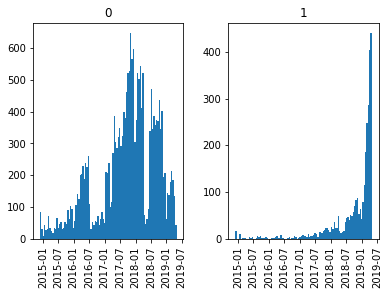

In [90]:
#определяем, если значение пропущено
df['missing_days_exposition'] = df['days_exposition'].isna().astype('int')
df.hist(column='first_day_exposition', by='missing_days_exposition', bins=100)

После работы с пропусками добавлю столбец с дистанцией до центра в километрах

In [91]:
df['centre_distance'] = (df['cityCenters_nearest']/1000).round(0).astype('int32')

Как можно заметить, больше всего пропусков перед последней датой публикацией

Cудя по всему пропуски, это данные, которые были опубликованы давно и не сняты. Эти данные нельзя заменять, поэтому они остаются неизменными.

## check

Теперь начинаем исследовательский анализ данных.

Начнем с общей площади

In [92]:
df['total_area'].describe()

count    23370.000000
mean        60.581673
std         35.613654
min         12.000000
25%         40.200000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

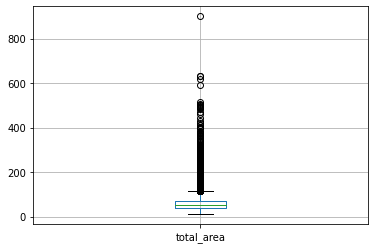

In [93]:
df.boxplot(column='total_area')

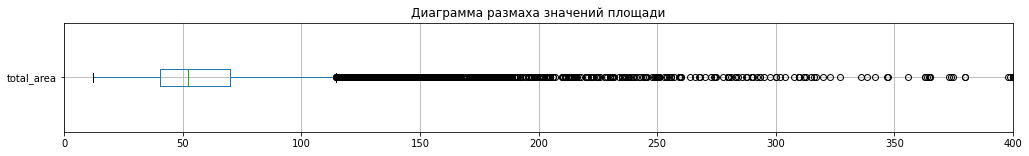

In [94]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = df[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

Строю гистограмму, отбросив значения выбивающиеся за диаграммы размаха

<AxesSubplot:>

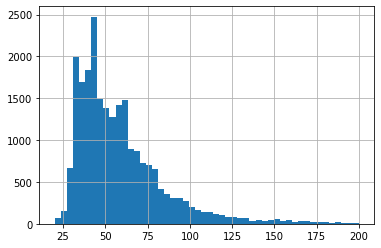

In [95]:
df['total_area'].hist(bins=50, range=(20, 200))

Вывод таков:
Самая популярная площадь квартиры приходится на 40-50 кв метров, дале популярность равномерно падает.

Стоимость квартиры

<AxesSubplot:>

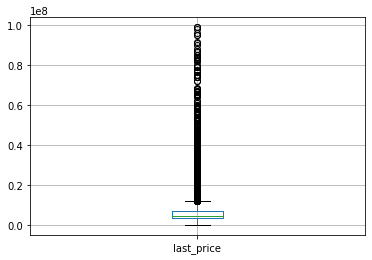

In [96]:
df.query('last_price <= 100000000').boxplot(column='last_price')


<AxesSubplot:>

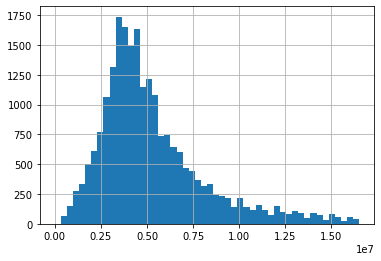

In [97]:
df['last_price'].hist(bins=50, range=(0, 16500000))

Вывод. Самая популярная цена для квартир находится в диапазоне от 3 миллионов до 4.75.

Далее посмотрим на цену за квадратный метр

<AxesSubplot:>

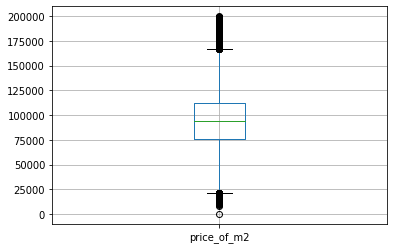

In [98]:
df.query('price_of_m2 < 200000').boxplot(column='price_of_m2')

<AxesSubplot:>

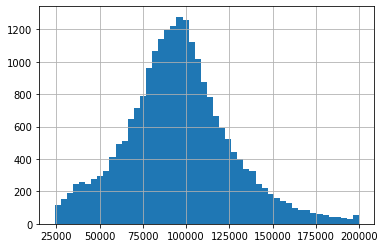

In [99]:
df['price_of_m2'].hist(bins=50, range=(24000, 200000))

Видим, что цена, которая больше всего пользуется спросом находится в диапазоне от 80000 до 110000 т.р.

Далее, количество комнат

<AxesSubplot:>

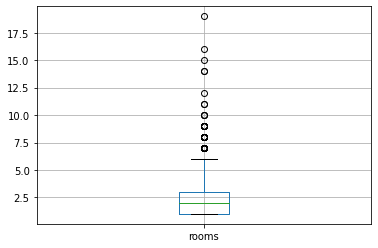

In [100]:
df.boxplot(column='rooms')

<AxesSubplot:>

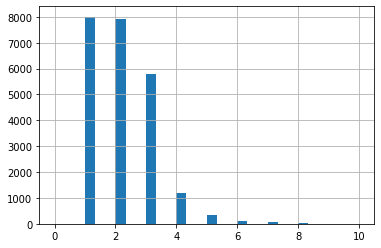

In [101]:
df['rooms'].hist(bins=30, range=(0,10))

Cамые популярные квартиры, это квартиры с одной до трех комнат. Квартиры, где больше 4 комнат - огромная редкость

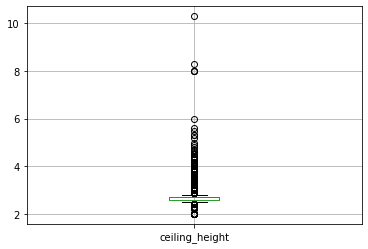

In [102]:
plt.ylim=(2,5)
df.boxplot(column='ceiling_height');


<AxesSubplot:>

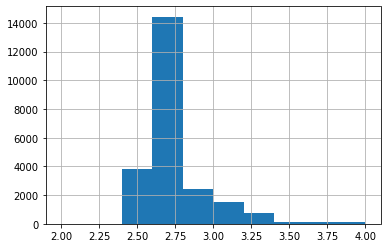

In [103]:
df['ceiling_height'].hist(bins=10, range=(2, 4))

Основаная высота потолков это потолки от двух до 2.75 метро.

In [104]:
df['living_area'].describe()

count    23370.000000
mean        34.454228
std         21.757390
min          2.000000
25%         18.500000
50%         30.500000
75%         42.800000
max        409.700000
Name: living_area, dtype: float64

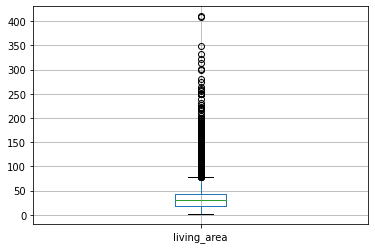

In [105]:
df.boxplot(column='living_area');

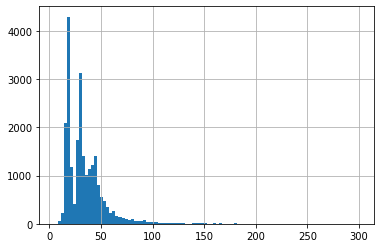

In [106]:
df['living_area'].hist(bins=100, range=(5, 300));

In [107]:
df['kitchen_area'].describe()

count    23370.000000
mean        10.454504
std          5.666123
min          1.300000
25%          7.300000
50%          9.000000
75%         11.500000
max        112.000000
Name: kitchen_area, dtype: float64

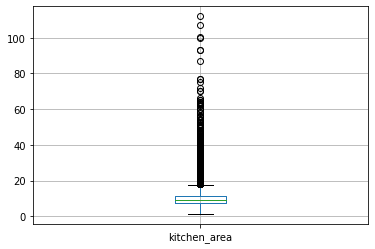

In [108]:
df.boxplot(column='kitchen_area');

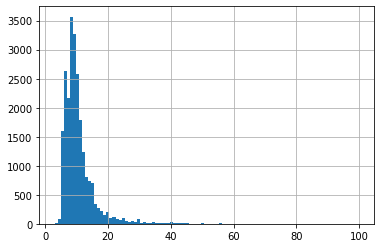

In [109]:
df['kitchen_area'].hist(bins=100, range=(3, 100));

Далее рассмотрим общее количество этажей

<AxesSubplot:>

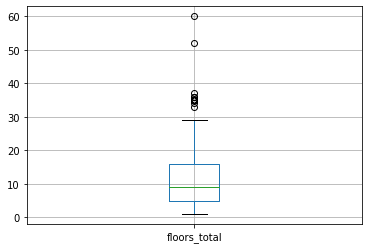

In [110]:
df.boxplot(column = 'floors_total')

Нормальным количеством считаются дома до 30 этажей. Все остальное выбросы

<AxesSubplot:>

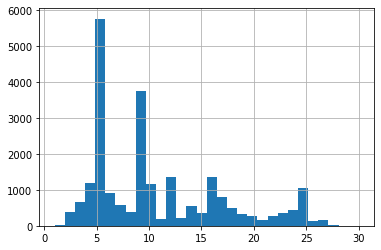

In [111]:
df['floors_total'].hist(bins=30, range=(1, 30))

<AxesSubplot:>

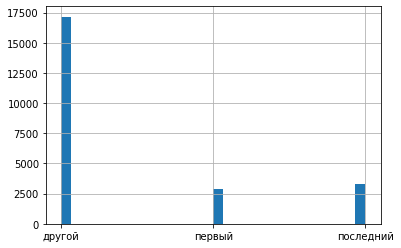

In [112]:
df['level'].hist(bins=30)

Очевидно, что больше всего квартир на продаже на не крайних этажах

<AxesSubplot:>

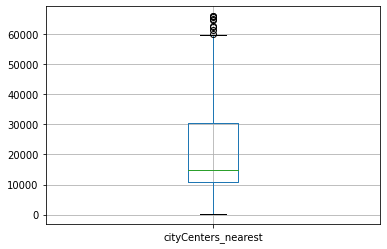

In [113]:
df.boxplot(column='cityCenters_nearest')

<AxesSubplot:>

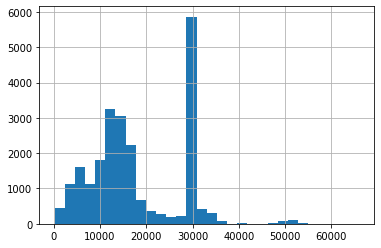

In [114]:
df['cityCenters_nearest'].hist(bins=30)

Больше всего квартир, которые удалены от центра на расстоянии в 30 километров. То, что дальше 55км будет считаться за выброс.

Все основные значения находятся не более чем в 60 километрах от центра

<AxesSubplot:>

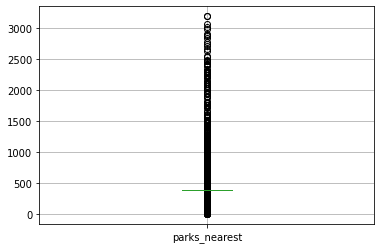

In [115]:
df.boxplot(column='parks_nearest')

Явно видно, что в област нормальных значений попадают парки находящиеся в диапазоне от 0 до 3.5 киллометров

<AxesSubplot:>

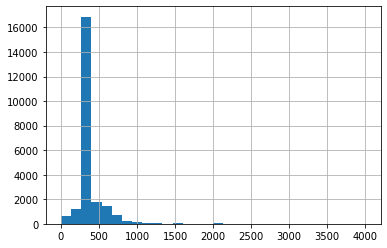

In [116]:
df['parks_nearest'].hist(bins=30, range=(0, 4000))

На гистограмме видим, что около 3000 всплеск значений, это вызвано нашим способом заполнения, ибо парки находятся за пределами. Оставим

Мы рассмотрели основные параметры квартир. Далее стоит построить таблицу нормальных значений.

### check gap 2

In [117]:
df_filtered = df.query('(total_area <= 200) and (total_area > 20) and (price_of_m2 <= 200000) and (rooms <= 7) and (ceiling_height >= 2.5) and (last_price>500000) and (ceiling_height <= 5) and (living_area > 10) and (kitchen_area > 3)  and (living_area < 200) and (kitchen_area < 45) and (cityCenters_nearest < 55000) and (floors_total < 30)' )
print('Процент удаленных строк:', 100 - (len(df_filtered) / len(df) * 100))
print('Количество удаленных строк:', len(df) - len(df_filtered))
df_filtered[['total_area', 'price_of_m2', 'rooms', 'ceiling_height']].describe()

df_filtered['days_exposition'].isna().sum()

Процент удаленных строк: 3.86392811296534
Количество удаленных строк: 903


2955

Теперь мы имеем таблицу без выбросов, ее мы будем использовать для исследования в дальнейшем.

In [118]:
# check
  
(
    df_filtered[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,467.00","22,467.00","22,467.00","19,512.00","22,467.00","22,467.00","22,467.00","22,467.00","22,467.00"
min,1.00,20.10,2.50,1.00,"520,000.00",10.10,3.20,1.00,1.00
max,7.00,200.00,5.00,"1,580.00","37,199,888.00",164.70,44.90,27.00,29.00


## check

# Теперь изучим, как продавались квартиры

In [119]:
df_filtered['days_exposition'].describe()

count    19512.000000
mean       178.899805
std        217.138780
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

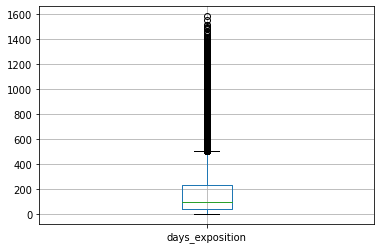

In [120]:
df_filtered.boxplot('days_exposition')

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

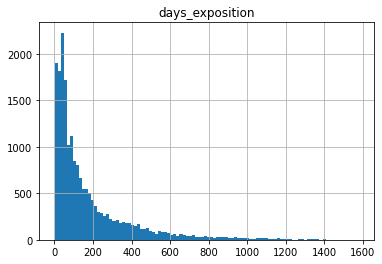

In [121]:
df_filtered.hist(column='days_exposition', bins=100)

# Больше всего значений встречаются до 250 дней. Построим гистограмму по этому диапазону

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

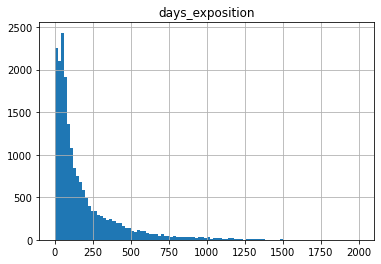

In [122]:
df_filtered.hist(column='days_exposition', bins=100, range=(0,2000))

# Есть выбивающиеся значения. Просмотрим часто встречающиеся значения

In [123]:
df_filtered['days_exposition'].value_counts().head(20)

45.0    852
60.0    529
7.0     222
30.0    198
4.0     168
90.0    166
3.0     150
5.0     139
14.0    138
20.0    136
9.0     134
44.0    130
8.0     130
11.0    130
10.0    125
18.0    123
6.0     121
13.0    121
21.0    120
28.0    119
Name: days_exposition, dtype: int64

# Значения 45 и 65 с выделяются больше всего. Их необходимо изучить отдельно

In [124]:
df_filtered.query('days_exposition == 45')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level,missing_days_exposition,centre_distance
78,9,4350000,37.0,2018-02-22,1,2.6,19,18.0,6,False,...,0.0,3190.0,45.0,117567.57,2018,2,4,другой,0,14
89,9,2500000,63.0,2018-10-25,3,2.5,5,43.0,4,False,...,0.0,3190.0,45.0,39682.54,2018,10,4,другой,0,31
110,6,3850000,72.3,2017-09-29,2,2.6,3,27.4,2,False,...,0.0,3190.0,45.0,53250.35,2017,9,5,другой,0,31
152,12,4350000,55.0,2017-05-21,2,2.6,9,31.2,2,False,...,0.0,3190.0,45.0,79090.91,2017,5,7,другой,0,34
157,15,3100000,47.3,2017-11-07,2,2.6,5,27.5,2,False,...,0.0,3190.0,45.0,65539.11,2017,11,2,другой,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23274,10,2900000,43.4,2018-01-11,2,2.6,5,30.5,1,False,...,2.0,397.0,45.0,66820.28,2018,1,4,первый,0,14
23286,4,3950000,52.0,2018-03-04,3,2.6,5,45.0,2,False,...,0.0,3190.0,45.0,75961.54,2018,3,7,другой,0,21
23341,9,2450000,45.6,2018-02-08,1,2.8,9,17.6,2,False,...,0.0,3190.0,45.0,53728.07,2018,2,4,другой,0,31
23350,0,2500000,35.0,2017-12-08,1,2.6,9,17.6,4,False,...,0.0,3190.0,45.0,71428.57,2017,12,5,другой,0,31


# Найдя в интернете особенности объявлений в яндекс недвижимости было выяснено, что у бесплатных объявлений есть срок экспирации. 

45 дней для квартир стоимостью до 4.5млн рублей
60 дней для квартир стоимостью от 4.5млн до 10млн
90 дней для квартир стомостью от 10 млн
120 дней для Москвы, Санкт-Петербурга и их областей

эти значения должны быть убраны, ибо могут сильно влиять на результаты, при этом быть мало информативными. Исключаю самые выбивающиеся значения

In [125]:
df_filtered = df_filtered.query('(days_exposition != 45) and (days_exposition != 60) and (days_exposition < 1200)')
df_filtered['days_exposition'].describe()

count    18050.000000
mean       183.549972
std        209.108176
min          1.000000
25%         42.000000
50%        106.000000
75%        243.750000
max       1199.000000
Name: days_exposition, dtype: float64

In [126]:
df_filtered.count()

total_images               18050
last_price                 18050
total_area                 18050
first_day_exposition       18050
rooms                      18050
ceiling_height             18050
floors_total               18050
living_area                18050
floor                      18050
is_apartment               18050
studio                     18050
open_plan                  18050
kitchen_area               18050
balcony                    18050
locality_name              18050
airports_nearest           14055
cityCenters_nearest        18050
parks_around3000           18050
parks_nearest              18050
ponds_around3000           18050
ponds_nearest              18050
days_exposition            18050
price_of_m2                18050
year                       18050
month                      18050
day                        18050
level                      18050
missing_days_exposition    18050
centre_distance            18050
dtype: int64

<AxesSubplot:>

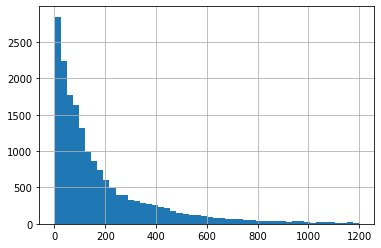

In [127]:
df_filtered['days_exposition'].hist(bins=50)

Видим Пуассоново распределение

# Строим коробку с усами

<AxesSubplot:>

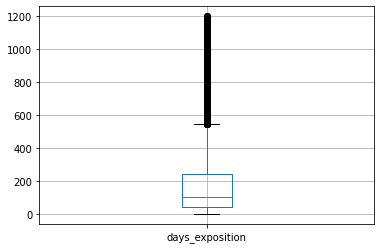

In [128]:

df_filtered.boxplot('days_exposition')

Основная масса значений в районе от 50 до 250

<AxesSubplot:>

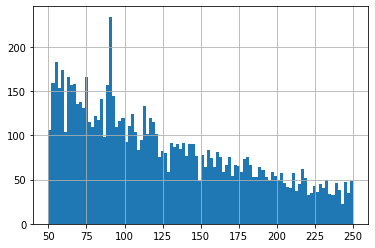

In [129]:
df_filtered['days_exposition'].hist(bins=100,range=(50,250))

<AxesSubplot:>

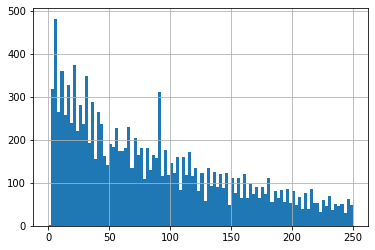

In [130]:
df_filtered['days_exposition'].hist(bins=100,range=(0,250))

# После исключения  аномалий, распределение продолжительности объявлений сместило среднее значение с примерно 500 до 600 дней. Среднее время, в течение которого объявления о продаже все еще, составляет примерно 184 дня, медиана же - 106 дней. На основе этих данных можно сделать вывод, что если квартира продается в течение первых 100 дней, это считается быстрой продажей, в то время, если квартира продается больше 240 дней это уже долгая продажа.

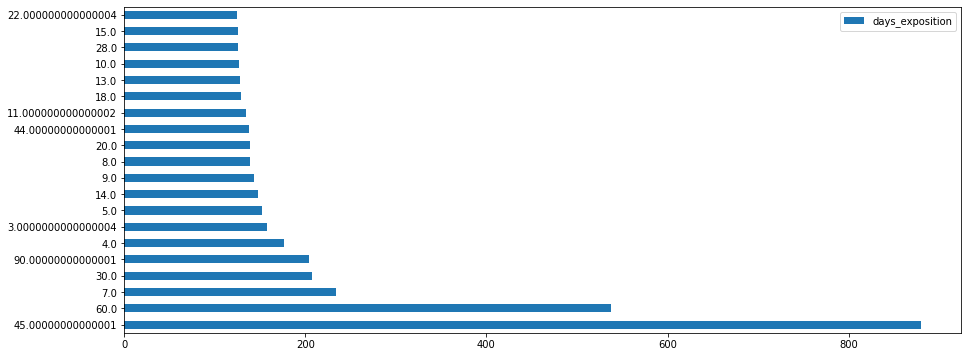

In [131]:
# check
# Моды на сырых данных
 
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

In [132]:
# check


(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,370.00","23,370.00","23,370.00","20,213.00","23,370.00","23,370.00","23,370.00","23,370.00","23,370.00"
min,1.00,12.00,2.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,10.30,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [133]:
# check


(
    df_filtered[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"18,050.00","18,050.00","18,050.00","18,050.00","18,050.00","18,050.00","18,050.00","18,050.00","18,050.00"
min,1.00,20.10,2.50,1.00,"520,000.00",10.10,3.20,1.00,1.00
max,7.00,200.00,5.00,"1,199.00","37,199,888.00",159.60,44.90,27.00,28.00


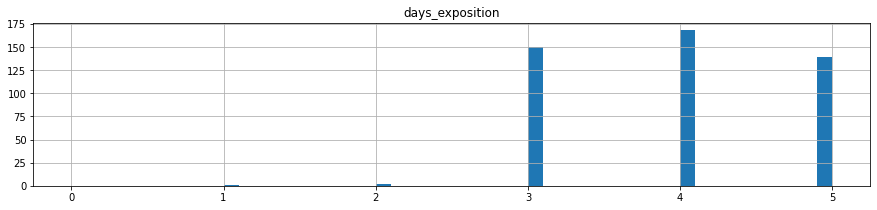

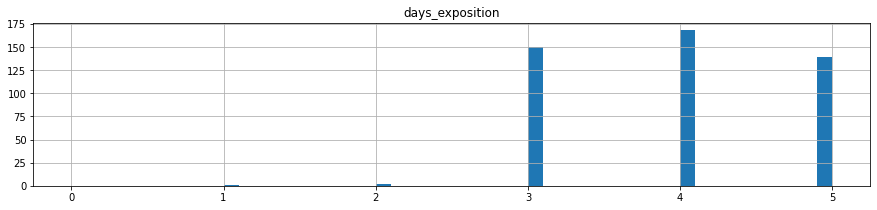

In [134]:
# check
df_filtered.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

df_filtered.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

# Изучение факторов влияющих на стоимость квартиры

## Просмотрим зависимость цены от площади

0.6531182197781309

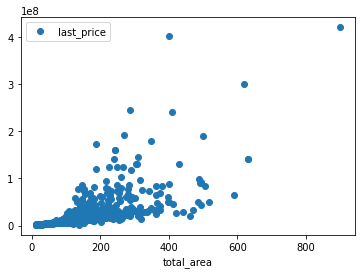

In [135]:
df.pivot_table(index='total_area', values='last_price', aggfunc='median').plot(style='o')
df['total_area'].corr(df['last_price'])

Корреляция есть, и она явная. Теперь рассмотрим данные на отфильтрованном датафрейме

0.8133744039788636

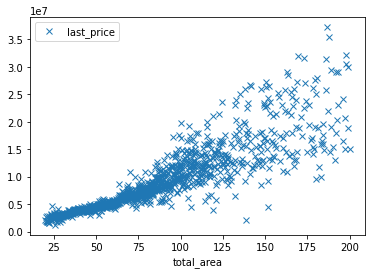

In [136]:
df_filtered.pivot_table(index='total_area', values='last_price', aggfunc='median').plot(style='x')
df_filtered['total_area'].corr(df_filtered['last_price'])

Вывод: Очевидно, что площадь квартиры прямо влияет на ее цену. Это иллюстрируют обе таблицы. Так же в отфильтрованной таблице, корреляция больше, чем в не отфильтрованной

# Посмотрим на зависимость цены от комнат

0.3646373893833864

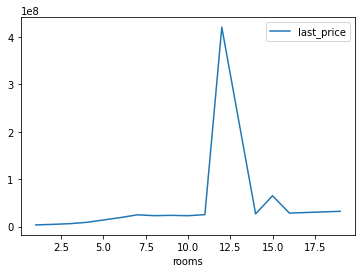

In [137]:
df.pivot_table(index='rooms', values ='last_price', aggfunc='median').plot(style='-')
df['rooms'].corr(df['last_price'])

In [138]:
df['rooms'].value_counts()

1     8003
2     7897
3     5779
4     1172
5      325
6      104
7       59
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

# Далее проделаем тоже самое с отфильтрованным датафреймом

0.5294477129198627

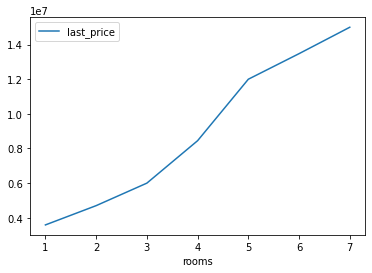

In [139]:
df_filtered.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(style='-')
df_filtered['rooms'].corr(df_filtered['last_price'])

In [140]:
df_filtered['rooms'].value_counts()

1    6522
2    6172
3    4315
4     811
5     181
6      38
7      11
Name: rooms, dtype: int64

## Вывод: И здесь корреляция явно присутствует. Мало значений с большим количеством комнат, но это нам не мешает сделать вывод. Чем больше комнат - тем выше стоимость квартиры, это можно утверждать наверняка, но постоянно есть просадка в секторе квартир с 5 комнатами, это мешает. Потому скорее буду утверждать, что есть зависимость, но прямой корреляции здесь может и не быть

# Далее зависимость цены от этажа

,last_price
level,
другой,4860000
первый,3900000
последний,4300000


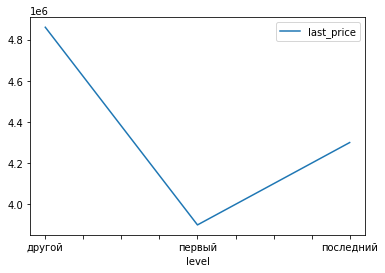

In [141]:
df.pivot_table(index='level', values='last_price', aggfunc='median').plot(style='-')
df.pivot_table(index='level', values='last_price', aggfunc='median')

,last_price
level,
другой,4700000
первый,3899000
последний,4250000


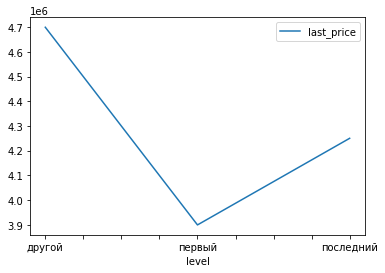

In [142]:
df_filtered.pivot_table(index='level', values='last_price', aggfunc='median').plot(style='-')
df_filtered.pivot_table(index='level', values='last_price', aggfunc='median')

# Очевидно, что самыми дорогими квартирами являются квартиры не на крайних этажах. Квартиры на последнем этаже по цене занимают второе место. На первом этаже, самые дешевые. Данные у отсортированной и не отсортированной таблицы практически идентичны.

# Зависимость цены от дня недели

,median,count
,last_price,last_price
day,,
1,4650000,3576
2,4750000,4128
3,4700000,3917
4,4654000,4238
5,4600000,3932
6,4600000,1907
7,4550000,1672


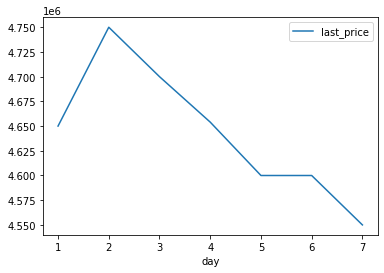

In [143]:
df.pivot_table(index='day', values='last_price', aggfunc='median').plot(style='-')
df.pivot_table(index='day', values='last_price', aggfunc=['median','count'])

,median,count
,last_price,last_price
day,,
1,4500000,2690
2,4600000,3213
3,4550000,3000
4,4550000,3334
5,4450000,3127
6,4500000,1434
7,4479000,1252


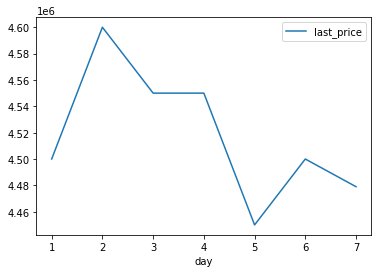

In [144]:
df_filtered.pivot_table(index='day', values='last_price', aggfunc='median').plot(style='-')
df_filtered.pivot_table(index='day', values='last_price', aggfunc=['median','count'])

Можно заметить, что пик цен приходится на вторник-среду, если смотреть на обе таблица. В не отсортированной минимум цен приходится на воскресенье, в отсортированной - четверг, пятница.
Однозначно можно сделать вывод, что пик цен приходится на начало неделии, и всегда ниже к концу.

# Зависимость цены от месяца

,median,count
,last_price,last_price
month,,
1,4600000,1475
2,4650000,2618
3,4691000,2558
4,4800000,2342
5,4500000,1253
6,4400000,1743
7,4650000,1668
8,4600000,1718


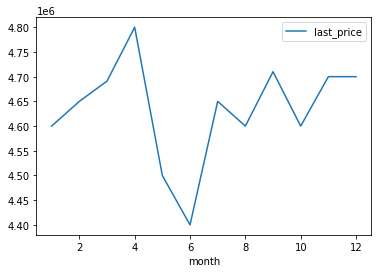

In [145]:
df.pivot_table(index='month', values='last_price', aggfunc='median').plot(style='-')
df.pivot_table(index='month', values='last_price', aggfunc=['median','count'])

,median,count
,last_price,last_price
month,,
1,4550000,1081
2,4597000,1962
3,4500000,1759
4,4500000,1371
5,4500000,1018
6,4370000,1467
7,4500000,1368
8,4500000,1434


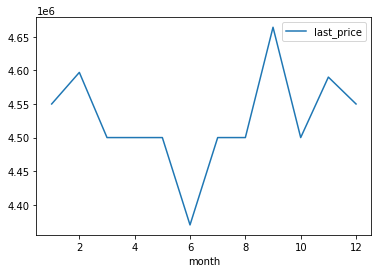

In [146]:
df_filtered.pivot_table(index='month', values='last_price', aggfunc='median').plot(style='-')
df_filtered.pivot_table(index='month', values='last_price', aggfunc=['median','count'])

В обоих таблицах видим тендецию резкого падения цен в июню. Так же пик ден наблюдается в апреле, вероятно майские праздники. Затем цена равномерно возвращается к средним значениям. На неотсортированной таблице цена стабильно идет вверх, и с октября по декабрь стабильна. На отсортированной видим, что с ноября по декабрь наблюдается падение перед новым годом, что выглядит логично, люди другим заняты

# Зависимость цены от года.

,median,count
,last_price,last_price
year,,
2014,7640000,136
2015,5324000,1163
2016,4550000,2741
2017,4500000,8062
2018,4600000,8414
2019,5100000,2854


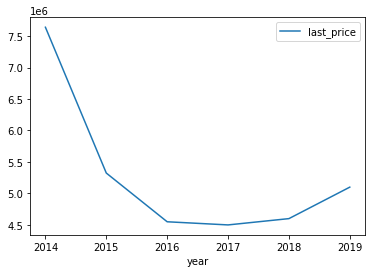

In [147]:
df.pivot_table(index='year', values='last_price', aggfunc='median').plot(style='-')
df.pivot_table(index='year', values='last_price', aggfunc=['median','count'])

,median,count
,last_price,last_price
year,,
2014,6200000,89
2015,5000000,969
2016,4450000,2466
2017,4490000,7053
2018,4500000,6510
2019,4799500,963


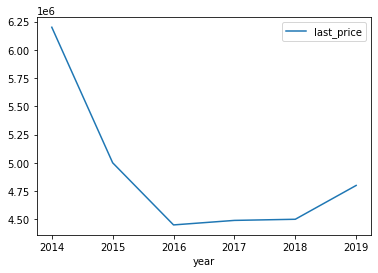

In [148]:
df_filtered.pivot_table(index='year', values='last_price', aggfunc='median').plot(style='-')
df_filtered.pivot_table(index='year', values='last_price', aggfunc=['median','count'])

Видим падение цен с 2014 года по 2017 в неотсортированной таблице и по 2016 в отсортированной. Далее следует восстановление цен к высоким значениям. Причина тому, сильный доллар и кризис 2014 года

,total_area
year,
2014,75.547191
2015,62.776058
2016,58.614801
2017,57.255211
2018,54.901459
2019,52.231672


<AxesSubplot:xlabel='year'>

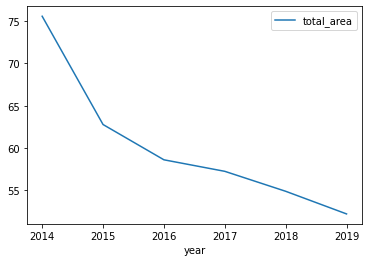

In [149]:
display(df_filtered.pivot_table(index='year', values='total_area', aggfunc='mean'))
df_filtered.pivot_table(index='year', values='total_area', aggfunc='mean').plot(style='-')

<AxesSubplot:xlabel='year'>

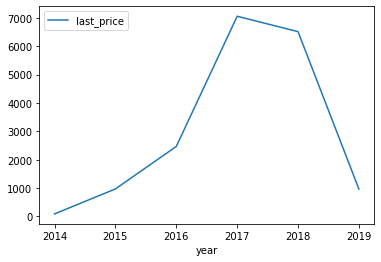

In [150]:
df_filtered.pivot_table(index='year', values='last_price', aggfunc='count')
df_filtered.pivot_table(index='year', values='last_price', aggfunc='count').plot(style='-')

In [151]:
df_filtered.pivot_table(index='year', values='total_area', aggfunc=['mean'])

,mean
,total_area
year,
2014,75.547191
2015,62.776058
2016,58.614801
2017,57.255211
2018,54.901459
2019,52.231672


Видим падение цен с 2014 года по 2017 в неотсортированной таблице и по 2016 в отсортированной. Далее следует восстановление цен к высоким значениям. Причина тому, сильный доллар и кризис 2014 года. Пик продаж наблюдался в 2017 году, вероятно с истерией из за кризиса. Далее количество объявлений, плавно начало падать. Так же можно заметить, что равномерно падает площадь продаваемых квартир, что может свидетельствовать о заинтересованности продавца, держать квартиры в большой площадью

# Зависимость цены от расстояния к центру

-0.26458178065476823

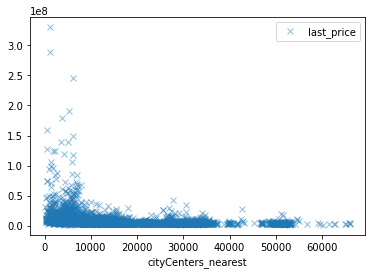

In [152]:
df.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='median').plot(style='x', alpha=0.5)
df['cityCenters_nearest'].corr(df['last_price'])

-0.4827691294714938

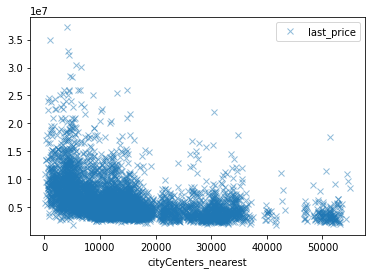

In [153]:
df_filtered.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='median').plot(style='x', alpha=0.5)
df_filtered['cityCenters_nearest'].corr(df['last_price'])

Исходя из коэффицента корелляции можно утверждать, что чем ближе квартира к центру, тем выше ее цена

# Теперь определим зависимость от жилой площади к цене

0.5562018665423166

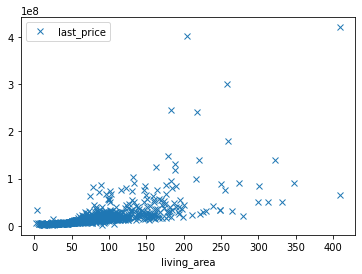

In [154]:
df.pivot_table(index='living_area', values='last_price', aggfunc='median').plot(style='x')
df['living_area'].corr(df['last_price'])

0.6864580253936728

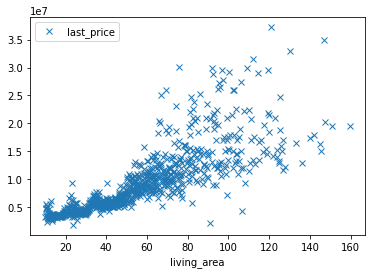

In [155]:
df_filtered.pivot_table(index='living_area', values='last_price', aggfunc='median').plot(style='x')
df_filtered['living_area'].corr(df_filtered['last_price'])

Вывод очевиден, чем больше жилая площадь, тем выше цена квартиры. Цена растет равномерно.

# Зависимость от площади кухни 

0.4542013264639859

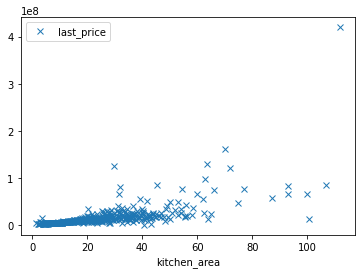

In [156]:
df.pivot_table(index='kitchen_area', values='last_price', aggfunc='median').plot(style='x')
df['kitchen_area'].corr(df['last_price'])

0.5717605593782659

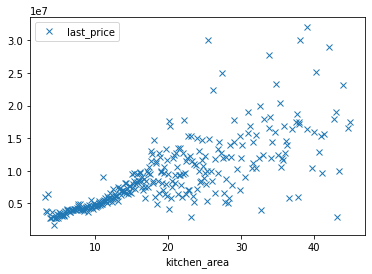

In [157]:
df_filtered.pivot_table(index='kitchen_area', values='last_price', aggfunc='median').plot(style='x')
df_filtered['kitchen_area'].corr(df['last_price'])

Вывод такой же, как и с жилой площадью. Встречаются исключения, но они точечны. В общем итоге чем больше площадь кухни, тем выше цена квартиры.

# Далее зависимость цены от населенного пункта 

In [158]:
top_city_pivot_df = df.pivot_table(index='locality_name', values='price_of_m2', aggfunc=['count','mean'])
top_city_pivot_df.columns = ['count', 'mean']
top_city_pivot_df.sort_values(by='count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15541,114776.678557
поселок Мурино,526,85029.524221
поселок Шушары,435,78277.935632
Всеволожск,392,68618.013724
Пушкин,369,103125.819377
Колпино,338,75424.579112
поселок Парголово,323,90289.778019
Гатчина,307,68746.146515
деревня Кудрово,283,92297.218834


<AxesSubplot:xlabel='locality_name'>

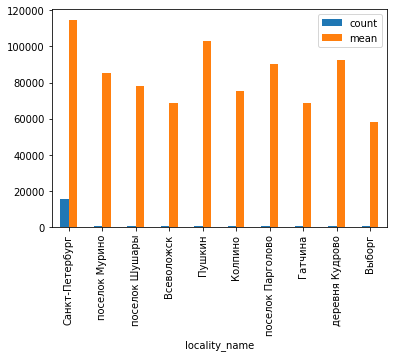

In [159]:
top_city_pivot_df.sort_values(by='count', ascending=False).head(10).plot(kind='bar')

In [160]:
top_city_pivot_filtered = df_filtered.pivot_table(index='locality_name', values='price_of_m2', aggfunc=['count','mean'])
top_city_pivot_filtered.columns = ['count', 'mean']
top_city_pivot_filtered.sort_values(by='count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,12115,106640.456844
поселок Мурино,480,84676.297312
поселок Шушары,368,77705.999022
Всеволожск,303,66661.987987
Пушкин,277,101193.560253
Колпино,274,75038.171825
поселок Парголово,260,89997.616346
деревня Кудрово,254,91851.947638
Гатчина,247,67588.922591


# Самая высокая цена за квадратный метр находится в Санкт-Петербурге с ценой в 104000. С самой низкой Выборг с средней ценой в 58000.

count    23370.000000
mean        18.093196
std         10.376281
min          0.000000
25%         11.000000
50%         15.000000
75%         31.000000
max         66.000000
Name: centre_distance, dtype: float64

count    18050.000000
mean        18.083213
std         10.125729
min          0.000000
25%         11.000000
50%         15.000000
75%         31.000000
max         55.000000
Name: centre_distance, dtype: float64

<AxesSubplot:xlabel='centre_distance'>

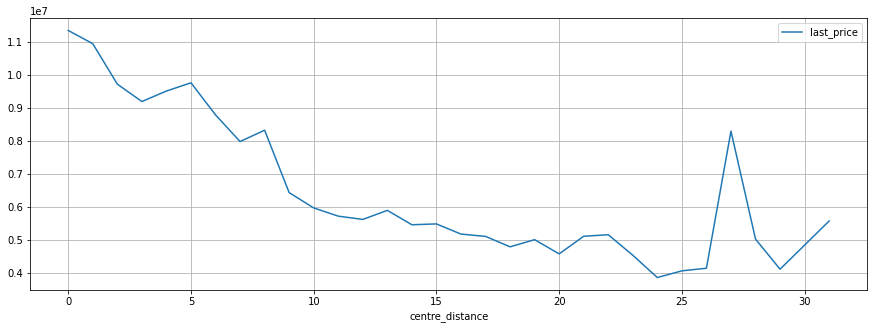

In [161]:
display(df['centre_distance'].describe())
display(df_filtered['centre_distance'].describe())

centre_pivot_df = (df_filtered.query('locality_name == "Санкт-Петербург"')
                  .pivot_table(index = 'centre_distance', values = 'last_price', aggfunc = 'mean')
)
centre_pivot_df.plot(figsize=(15,5), grid=True)

In [162]:
display(df_filtered.query('centre_distance == 27 and (locality_name == "Санкт-Петербург")').pivot_table(index='locality_name', values = 'centre_distance', aggfunc="count"))

,centre_distance
locality_name,
Санкт-Петербург,2


 Все эти места равноудаленны от центра, просто находятся по разные стороны. Отсюда такой выброс. Ничего анамального. Смущает только сам Санкт-Петербург. Вероятно не был указан населенный пункт.

До 5 киллометров можно предположить, что это слишком малое расстояние, чтобы что либо утверждать, поскольку это все еще может быть центр. Расстояние далее стабильно падает, значит все, что за расстоянием 5 километров уже уходит дальше центра.

In [163]:
spb_df_level = df_filtered.query('locality_name == "Санкт-Петербург"')

spb_df_level.query('level == "другой" and centre_distance == 3 ').pivot_table(index = 'centre_distance', values = 'level', aggfunc='count')
spb_df_level.query('centre_distance == 3 ').pivot_table(index='centre_distance', values = 'level', aggfunc='count')

(spb_df_level.query('level == "другой" and centre_distance == 3 ').count() / spb_df_level.query('centre_distance == 3').count())['level']

0.5951417004048583

Половину всех значений на расстоянии трех километров занимает самая дорогая категория квартир. Которые находятся не на крайних этажах. Но это значение сильно ниже чем на 5 километрах, что показано выше. Ниже на половину.

In [164]:
spb_df_level = df_filtered.query('locality_name == "Санкт-Петербург"')

spb_df_level.query('level == "другой" and centre_distance == 5 ').pivot_table(index = 'centre_distance', values = 'level', aggfunc='count')
spb_df_level.query('centre_distance == 5 ').pivot_table(index='centre_distance', values = 'level', aggfunc='count')

(spb_df_level.query('level == "другой" and centre_distance == 5 ').count() / spb_df_level.query('centre_distance == 5').count())['level']

0.7580128205128205

In [165]:
display((spb_df_level.query('level == "другой"').count() / spb_df_level['level'].count())['level'])

0.7762278167560875

77 процентных пунктов, самые популярные квартиры на продаже - квартиры на не крайних этажах

In [166]:
display((spb_df_level.query('level == "последний"').count() / spb_df_level['level'].count())['level'])

0.12059430458109781

Последние этажи занимают примерно 12 процентных пунктов от всего количества.

In [167]:
display((spb_df_level.query('level == "первый"').count() / spb_df_level['level'].count())['level'])

0.10317787866281469

Здесь видим 10.5 процентных пункта.

In [177]:
display(spb_df_level.query('centre_distance == 27'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_of_m2,year,month,day,level,missing_days_exposition,centre_distance
737,13,14350000,74.0,2017-11-28,2,3.1,5,30.0,3,False,...,0.0,3190.0,128.0,193918.92,2017,11,2,другой,0,27
5880,6,2250000,32.0,2018-02-27,1,2.6,2,16.5,2,False,...,0.0,3190.0,178.0,70312.50,2018,2,2,последний,0,27


In [169]:
 final_df = spb_df_level.query('level == "другой"').pivot_table(
    index='centre_distance',
    values='level',
    aggfunc='count'
)


# final_df

level_count_df =df_filtered.pivot_table(index='centre_distance',
    values='level',
    aggfunc='count')
final_df = final_df['level'] / level_count_df['level']

#final_df


final_df

centre_distance
0     0.727273
1     0.629921
2     0.556701
3     0.595142
4     0.707317
5     0.758013
6     0.738155
7     0.769517
8     0.787879
9     0.748373
10    0.773356
11    0.774397
12    0.793077
13    0.816225
14    0.812016
15    0.813679
16    0.792360
17    0.763661
18    0.533123
19    0.335593
20    0.181818
21    0.495868
22    0.777108
23    0.529412
24    0.202128
25    0.266667
26    0.220930
27    0.011905
28    0.046512
29         NaN
30         NaN
31    0.002848
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
37         NaN
39         NaN
40         NaN
41         NaN
42         NaN
43         NaN
47         NaN
48         NaN
49         NaN
50         NaN
51         NaN
52         NaN
53         NaN
54         NaN
55         NaN
Name: level, dtype: float64

Можно четко увидеть, что начиная с 29 километров. Объявлений с не крайними квартирами нет. В остальном доля квартир не на крайних этажах высока, но падает по мере отдаления от центра

Здесь уже интереснее, можно понять, что данных о 27 киллометре мало в принципе. Здесь всего две квартиры в принципе. Потому и возможнен данный выброс

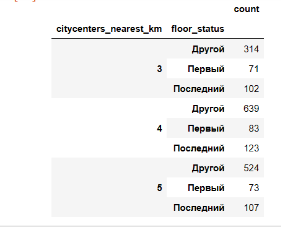

Рассмотрим динамику до 15 киллометров

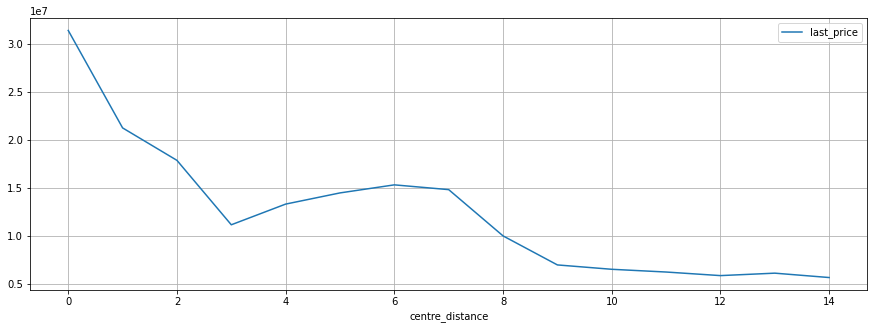

In [170]:
centre_pivot_df = (df.query('locality_name == "Санкт-Петербург" & centre_distance < 15')
                  .pivot_table(index = 'centre_distance', values = 'last_price', aggfunc = 'mean')
)
centre_pivot_df.plot(figsize=(15,5), grid=True);

In [171]:
centre_pivot_df.query('centre_distance < 15')/1000

,last_price
centre_distance,
0,31449.115852
1,21274.818843
2,17886.620390
3,11160.557207
4,13320.477898
5,14487.517536
6,15328.418270
7,14830.225086
8,10000.599932


# Вывод: Можно увидеть, что чем дальше квартира от центра, тем она дешевле. Заметна сильная просадка в трех километрах от центра, дальше цена растет до 6 километров, а затем равномерно падает. Можно сделать вывод, что цена падает по мере отдаления от центра.

# Общий вывод:

## Был изучен датафрейм по продаже квартир с периода 2014 по 2019 год с выборками по населенным пунктам. Нам удалось выяснить следующее:

### Чем больше площадь квартиры - тем больше ее цена.
Были выявлены факторы, которые больше всего влияют на цену, они указаны ниже.

Чем больше жилой и кухонной площади квартиры - тем больше ее цена 

Квартиры в центре стоят больше чем квартиры, которые находятся дальше.

Прослеживается зависимость цен от дня, месяца, года публикации.

Стоимость квартиры на первых этажах самая низкая, чуть выше на последнем, и выше всего на других.

Чем больше количество комнат, тем выше цена квартиры

В период 2014 по 2016 год рынок переживал сильное падение цен, потом цены стали восстанавливаться на предыдущие уровни
Бесплатные объявления автоматически снимаются в зависимости от цены и населенного пункта через 45, 60, 90 и 120 дней.

Часть объявлений было без указанания населенного пункта. Вероятнее всего это был какой-то сбой или отсутсвовала пометка обязательного поля.

Была выяснена средняя стоимость в СПБ на разном удалении от центра. 

Было выяснено, как быстро продавались квартиры. Быстрой продажей считается до 100 дней, долгой после 240.

Можно четко увидеть, что начиная с 29 километров. Объявлений с не крайними квартирами нет. В остальном доля квартир не на крайних этажах высока, но падает по мере отдаления от центра

Можно понять, что данных о 27 киллометре мало в принципе. Здесь всего две квартиры в принципе. Потому и возможнен данный выброс

Так же четко видна тенденция спада продаж квартир с большой площадью

После кризиса количество объявлений снижается. Пик подач объявлений приходится на 2017 год.

### Напишите общий вывод

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

In [172]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
# check
data = df_filtered.copy()

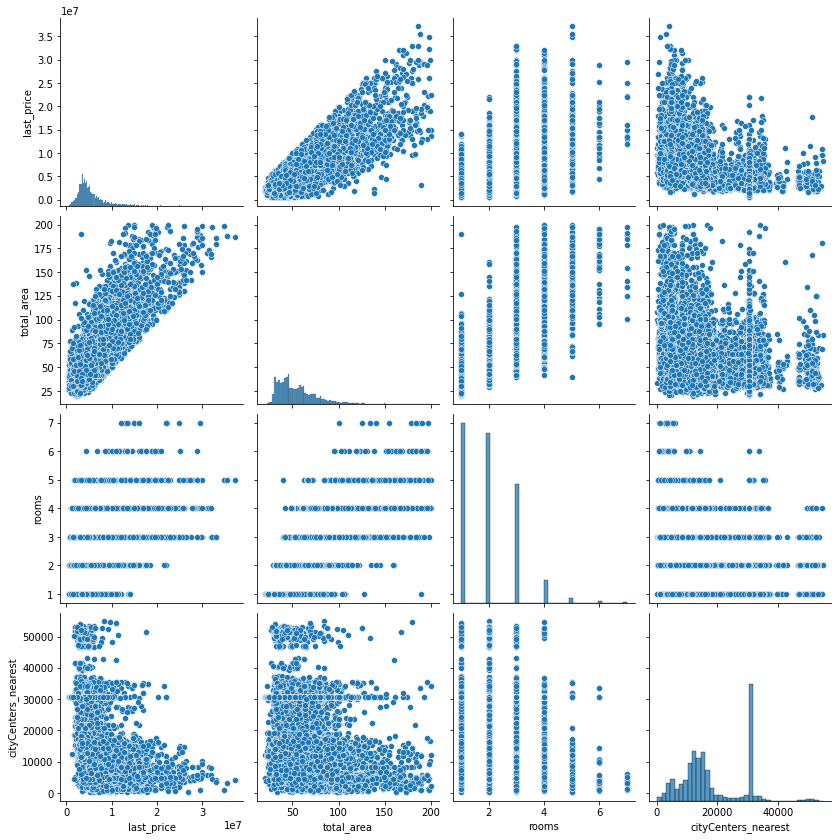

In [174]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


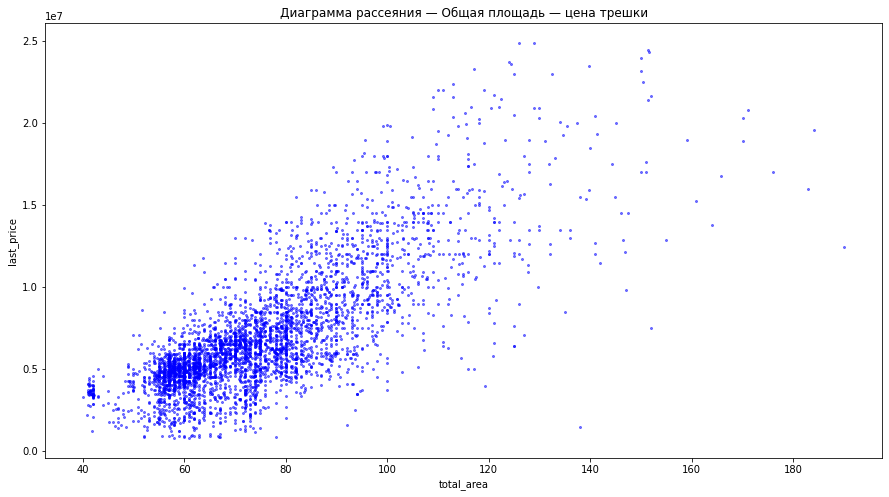

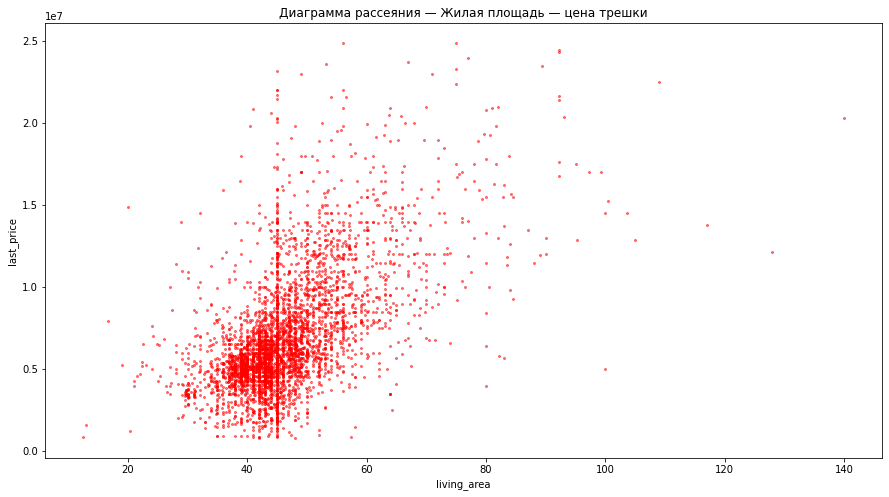

In [175]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');